### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Three_Class_Models", "saved_models", "PSR_hybrid_best.pth")

### Load PSR dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)
# pick RRI feature columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"


In [3]:
def phase_space_reconstruct(x, m=3, tau=1):
    """
    x: 1D array of RRI
    m: embedding dimension
    tau: time delay
    Returns flattened PSR embedding: x(t), x(t+tau), ..., x(t+(m-1)*tau)
    """
    x = np.asarray(x)
    N = len(x)
    if N < (m-1)*tau + 1:
        # pad with zeros if too short
        x = np.pad(x, (0, (m-1)*tau + 1 - N), 'constant')
        N = len(x)
    psr_vectors = [x[i:N-(m-1)*tau + i] for i in range(m)]
    psr_flat = np.column_stack(psr_vectors).flatten()
    return psr_flat

# Pick RRI columns
rri_cols = [f"r_{i}" for i in range(50)]

# Compute PSR for all rows with m=3, tau=2
psr_features = df[rri_cols].apply(lambda row: phase_space_reconstruct(row.values, m=3, tau=2), axis=1)
psr_features = np.stack(psr_features.values)  # shape: (num_samples, m*(N-(m-1)*tau))

# Add PSR columns to DataFrame
num_psr_cols = psr_features.shape[1]
psr_col_names = [f"psr_{i}" for i in range(num_psr_cols)]
df_psr = pd.DataFrame(psr_features, columns=psr_col_names, index=df.index)
df = pd.concat([df, df_psr], axis=1)

print("PSR features added (m=3, tau=2). DataFrame shape:", df.shape)




PSR features added (m=3, tau=2). DataFrame shape: (14357, 193)


In [4]:
feature_cols = psr_col_names
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

# Feature matrix X
X = df[feature_cols].values.astype(np.float32)

# Keep label as float first (to handle NaN/inf safely)
y_raw = df["label"].values

# Step 1: Drop rows with invalid X (NaN or inf)
mask_good = np.isfinite(X).all(axis=1)

# Step 2: Drop invalid labels (NaN, inf, negative)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)

# Apply combined mask
X = X[mask_good]
y = y_raw[mask_good].astype(int)

# Step 3: Inspect
print(np.unique(y)[:10])   # print first few unique labels
print(y[:20])

# Step 4: Safe bincount
print("Loaded samples:", X.shape, "class counts:", np.bincount(y))


[0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loaded samples: (14357, 138) class counts: [4800 4757 4800]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SMOTE on training only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.bincount(y_train_res))

Splits -> train: (9188, 138) val: (2297, 138) test: (2872, 138)


c:\Users\Michelle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE train distribution: [3072 3072 3072]


### Compute class weights

In [6]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [1. 1. 1.]


### Compute focal loss

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

### Define model class

In [8]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [9]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (k-fold + hyperparameter tuning)

In [10]:
import itertools
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
import torch.optim as optim         
from torch.utils.data import DataLoader, Subset
 

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, class_weights_tensor,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    class_weights_tensor = class_weights_tensor.to(device)
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            # --- Model + Optimizer + Criterion ---
            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            
            if params["optimizer"] == "adam":
                optimizer = optim.Adam(model.parameters(), lr=params["lr"])
            elif params["optimizer"] == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            else:
                raise ValueError(f"Unknown optimizer: {params['optimizer']}")

            criterion = FocalLoss(alpha=class_weights_tensor, gamma=params.get("gamma", 2.0))

            # --- Training loop ---
            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # --- Validation ---
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state


In [11]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [12]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset, class_weights_tensor,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6039
  Fold 2/5 F1: 0.5782
  Fold 3/5 F1: 0.5713
  Fold 4/5 F1: 0.6255
  Fold 5/5 F1: 0.6230
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.6004
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.5932
  Fold 2/5 F1: 0.5675
  Fold 3/5 F1: 0.5739
  Fold 4/5 F1: 0.5854
  Fold 5/5 F1: 0.6046
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.5849

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6128
  Fold 2/5 F1: 0.5952
  Fold 3/5 F1: 0.5767
  Fold 4/5 F1: 0.6182
  Fold 5/5 F1: 0.5973
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.6000

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.5883
  Fold 2/5 F1

### Final evaluation on test set

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.6170
F1 Score:  0.5982
Precision: 0.6295
Recall:    0.6170

Detailed classification report:
              precision    recall  f1-score   support

           0     0.4900    0.7211    0.5835       950
           1     0.5881    0.2837    0.3828       941
           2     0.8099    0.8432    0.8262       950

    accuracy                         0.6170      2841
   macro avg     0.6293    0.6160    0.5975      2841
weighted avg     0.6295    0.6170    0.5982      2841


Confusion Matrix:
[[685 161 104]
 [590 267  84]
 [123  26 801]]


In [12]:
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(DEVICE)
state_dict = torch.load(OUT_MODEL, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained NODE model from", OUT_MODEL)

✅ Loaded trained NODE model from ..\Three_Class_Models\saved_models\PSR_hybrid_best.pth


In [ ]:
import torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import numpy as np

# --- Load model from saved .pth ---
model_path = os.path.join("..", "Three_Class_Models", "saved_models", "PSR_hybrid_best.pth")

# ✅ use the exact same model class you trained
best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)

# ✅ load trained weights
state_dict = torch.load(model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()
print(f"✅ Loaded trained model from: {model_path}")

# --- Evaluate on test set ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Compute metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded trained model from: ..\Three_Class_Models\saved_models\PSR_hybrid_best.pth

📊 Final Test Results:
Accuracy:  0.6041
F1 Score:  0.5862
Precision: 0.6117
Recall:    0.6041

Detailed classification report:
              precision    recall  f1-score   support

           0     0.4785    0.7073    0.5708       960
           1     0.5332    0.2700    0.3584       952
           2     0.8229    0.8323    0.8276       960

    accuracy                         0.6041      2872
   macro avg     0.6115    0.6032    0.5856      2872
weighted avg     0.6117    0.6041    0.5862      2872


Confusion Matrix:
[[679 190  91]
 [614 257  81]
 [126  35 799]]


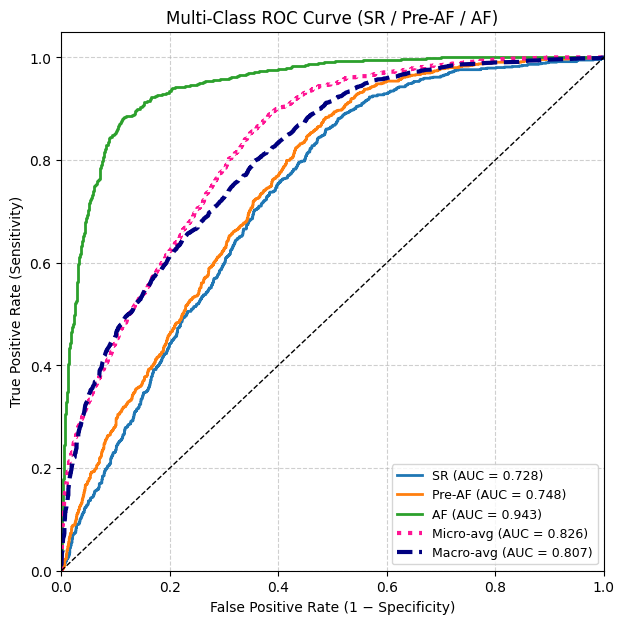

AUC[SR] = 0.7281
AUC[Pre-AF] = 0.7480
AUC[AF] = 0.9433
Micro-avg AUC = 0.8257
Macro-avg AUC = 0.8068


In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# --- Assuming you already have test_loader, model, and y_all defined ---

num_classes = 3
y_all = [label for _, label in test_dataset]
y_true = np.array(y_all)  # labels: 0=SR, 1=Pre-AF, 2=AF

# --- Compute full probability matrix [N, 3] ---
probs_all = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)   # shape [n_samples, 3]

# --- One-hot encode true labels ---
y_bin = label_binarize(y_true, classes=[0, 1, 2])

# --- Compute ROC curve & AUC for each class ---
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro- and macro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ---
plt.figure(figsize=(7,7))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
class_names = ["SR", "Pre-AF", "AF"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=3,
         label=f"Micro-avg (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--", linewidth=3,
         label=f"Macro-avg (AUC = {roc_auc['macro']:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Multi-Class ROC Curve (SR / Pre-AF / AF)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Print numeric results ---
for i, name in enumerate(class_names):
    print(f"AUC[{name}] = {roc_auc[i]:.4f}")
print(f"Micro-avg AUC = {roc_auc['micro']:.4f}")
print(f"Macro-avg AUC = {roc_auc['macro']:.4f}")


### Find Threshold

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix, classification_report
)

# --- Ensure test_loader exists ---
test_dataset = TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.int64))
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Compute probability of danger = 1 - P(SR) ---
prob_danger, true_danger = [], []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  # shape [batch, 3]
        p_sr = probs[:, 0]             # SR probability
        p_danger = 1 - p_sr            # Pre-AF + AF
        prob_danger.extend(p_danger.cpu().numpy())

        # label = 0 (SR), 1 (Pre-AF), 2 (AF)
        # For danger thresholding, combine Pre-AF + AF as 1
        danger_labels = (yb.numpy() != 0).astype(int)
        true_danger.extend(danger_labels)

prob_danger = np.array(prob_danger)
true_danger = np.array(true_danger)

print("🔍 Probability range:", prob_danger.min(), "-", prob_danger.max())
print("Label distribution (0=SR, 1=Danger):", np.bincount(true_danger))

🔍 Probability range: 0.23810929 - 0.90945256
Label distribution (0=SR, 1=Danger): [ 960 1912]


In [27]:
# --- Sweep thresholds (coarse + fine around 0.45–0.50) ---
coarse = np.arange(0.0, 1.01, 0.05)
fine = np.arange(0.45, 0.501, 0.01)   # 0.45, 0.46, 0.47, 0.48, 0.49, 0.50
candidates = np.unique(np.concatenate([coarse, fine]))

f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger >= t).astype(int)
    f1s.append(f1_score(true_danger, preds))
    accs.append(accuracy_score(true_danger, preds))
    precs.append(precision_score(true_danger, preds, zero_division=0))
    recs.append(recall_score(true_danger, preds))

# --- Pick best threshold by (F1 + Acc)/2 ---
scores = [(f1s[i] + accs[i]) / 2 for i in range(len(candidates))]
best_idx = np.argmax(scores)
best_t = candidates[best_idx]

print(f"\n✅ Best threshold = {best_t:.3f}")
print(f"F1={f1s[best_idx]:.4f}, Acc={accs[best_idx]:.4f}, "
      f"Prec={precs[best_idx]:.4f}, Rec={recs[best_idx]:.4f}")



✅ Best threshold = 0.460
F1=0.7988, Acc=0.6737, Prec=0.6776, Rec=0.9728


In [28]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.7993     0.6657    
0.05       0.7993     0.6657    
0.10       0.7993     0.6657    
0.15       0.7993     0.6657    
0.20       0.7993     0.6657    
0.25       0.8004     0.6682    
0.30       0.8002     0.6682    
0.35       0.7998     0.6678    
0.40       0.7993     0.6671    
0.45       0.7990     0.6713    
0.46       0.7988     0.6737    
0.47       0.7955     0.6762    
0.48       0.7895     0.6783    
0.49       0.7812     0.6765    
0.50       0.7760     0.6769    
0.55       0.7308     0.6668    
0.60       0.6617     0.6341    
0.65       0.6235     0.6156    
0.70       0.5690     0.5843    
0.75       0.5027     0.5474    
0.80       0.4113     0.5007    
0.85       0.2561     0.4276    
0.90       0.0083     0.3360    
0.95       0.0000     0.3343    
1.00       0.0000     0.3343    


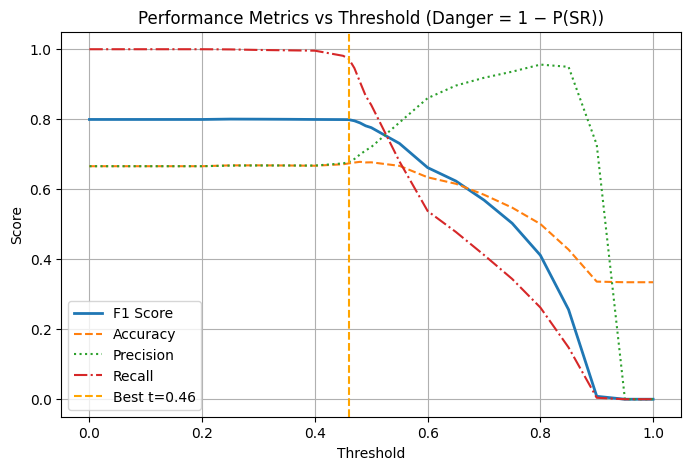

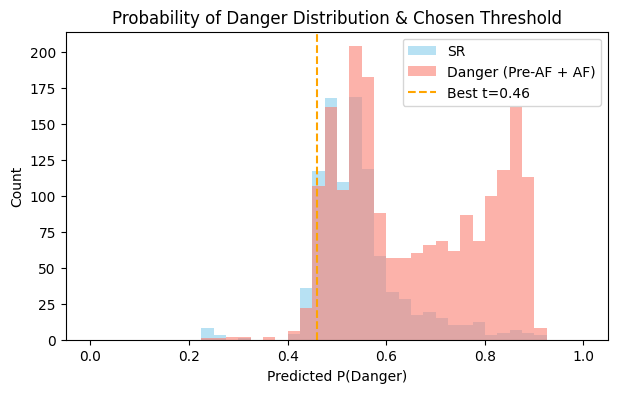

In [29]:
# --- Plot metric trends across thresholds ---
plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Danger = 1 − P(SR))")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot probability distributions ---
plt.figure(figsize=(7,4))
plt.hist(prob_danger[true_danger==0], bins=40, range=(0,1), alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger[true_danger==1], bins=40, range=(0,1), alpha=0.6, label="Danger (Pre-AF + AF)", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Probability of Danger Distribution & Chosen Threshold")
plt.legend()
plt.show()


### Find mean predicted time horizon

In [30]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

# --- Config ---
DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
threshold = 0.46
window_duration_sec = 30  # adjust if needed

# --- Reload and clean the dataset (post-training) ---
df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

# Drop invalid feature or label rows (like before)
X = df[feature_cols].values.astype(np.float32)
y_raw = df["label"].values
mask_good = np.isfinite(X).all(axis=1)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)
df_clean = df.loc[mask_good].reset_index(drop=True)

aligned_record_ids = df_clean["record_id"].values
y_all = df_clean["label"].values.astype(int)

print("✅ Reloaded clean dataset:", df_clean.shape)
print("Unique records:", len(np.unique(aligned_record_ids)))

# --- Compute danger probabilities using the trained model ---
prob_danger = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:        # same test_loader used earlier
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)
        p_sr = probs[:, 0]
        p_danger = 1 - p_sr
        prob_danger.extend(p_danger.cpu().numpy())

prob_danger = np.array(prob_danger)

# --- Trim if dataset is longer than predictions ---
if len(prob_danger) != len(aligned_record_ids):
    min_len = min(len(prob_danger), len(aligned_record_ids))
    prob_danger = prob_danger[:min_len]
    aligned_record_ids = aligned_record_ids[:min_len]
    y_all = y_all[:min_len]
    print(f"⚠️ Trimmed arrays to same length = {min_len}")

# --- Find AF onset per record ---
record_af_onset_indices = {}
for rid in np.unique(aligned_record_ids):
    idxs = np.where(aligned_record_ids == rid)[0]
    labels = y_all[idxs]
    af_idx = np.where(labels == 2)[0]
    if len(af_idx) > 0:
        record_af_onset_indices[rid] = af_idx[0]

print(f"✅ Found AF onset in {len(record_af_onset_indices)} records")

# --- Compute predicted time horizon ---
time_horizons = []
for rid in record_af_onset_indices.keys():
    idxs = np.where(aligned_record_ids == rid)[0]
    probs = prob_danger[idxs]
    first_alert = np.where(probs >= threshold)[0]
    af_onset_idx = record_af_onset_indices[rid]

    if len(first_alert) > 0 and first_alert[0] < af_onset_idx:
        delta_windows = af_onset_idx - first_alert[0]
        time_horizons.append(delta_windows * window_duration_sec)

# --- Summary ---
if len(time_horizons) > 0:
    mean_horizon = np.mean(time_horizons)
    median_horizon = np.median(time_horizons)
    print(f"\n✅ Mean predicted time horizon: {mean_horizon:.2f} s")
    print(f"Median predicted time horizon: {median_horizon:.2f} s")
    print(f"Detected {len(time_horizons)} AF records with early alerts.")
else:
    print("\n⚠️ No early detections above threshold found.")


✅ Reloaded clean dataset: (14357, 55)
Unique records: 96
⚠️ Trimmed arrays to same length = 2872
✅ Found AF onset in 19 records

✅ Mean predicted time horizon: 2990.53 s
Median predicted time horizon: 3000.00 s
Detected 19 AF records with early alerts.
